In [1]:
%pylab inline
import scipy

Populating the interactive namespace from numpy and matplotlib


# Data-driven basis functions for radial q-space

## Load data

In [2]:
from dwichd.io import load_mrtrix

I = load_mrtrix('/data/SH-SVD/workup/s02/dwi.mif')
data = I.data
grad = I.grad
grad[:,3] = np.round(grad[:,3], -2)


In [3]:
bvals, bcounts = np.unique(grad[:,3], return_counts=True)
M = len(bvals)
print(bvals)
print(bcounts)

qvals = sqrt(bvals)

[    0.   100.   400.   900.  1600.  2500.  3600.  4900.  6400.  8100.
 10000.]
[ 15  16  19  24  31  40  51  64  79  96 115]


In [4]:
mask = np.squeeze(load_mrtrix('/data/SH-SVD/workup/s02/mask.mif').data > .5)

In [5]:
import gc
gc.collect()

20

In [6]:
sliceidx = data.shape[2]//2

## Multi-shell SH fit

In [7]:
scale = sqrt([sum(grad[:,3]==b) for b in bvals])[:,newaxis]
scale /= sum(scale)/M
print(scale.T)

[[0.5790427  0.59803273 0.65169106 0.73243752 0.83242633 0.94557277
  1.06770198 1.19606546 1.32885779 1.46487503 1.60329664]]


Laplace-Beltrami regularization:

In [31]:
#from dwichd import msmt
from dwichd.sh import modshbasiscart

def calcsig(dwi, grad, lmax=8, reg=1e-3):
    '''
    Multi-shell DWI fit in the SH basis with Laplace-Beltrami regularization.
    '''
    bvals = list(set(grad[:,3]))
    bvals.sort()
    Bfull = modshbasiscart(lmax, grad[:,0], grad[:,1], grad[:,2])
    L = np.diag([-l*(l+1) for l in range(0,lmax+1,2) for m in range(-l,l+1)])
    n = (lmax+1)*(lmax+2)//2
    S = np.zeros(dwi.shape[:-1]+(len(bvals),n))
    f, r = 0.0, 0.0
    for k, b in enumerate(bvals):
        bidx = grad[:,3]==b
        nn = n if b>50. else 1 # max([(l+1)*(l+2)//2 for l in range(0,lmax+1,2) if (l+1)*(l+2)//2 <= np.sum(bidx)]) if b>50. else 1
        B = Bfull[bidx,:nn]
        gamma = sqrt(np.sum(bidx)) * reg * 1000./b if b>50. else 0.
        pinvB = np.dot( np.linalg.inv(np.dot(B.T, B) + gamma**2 * L[:nn,:nn]**2) , B.T)
        S[...,k,:nn] = np.dot(dwi[...,bidx], pinvB.T)
    return S

lmax = 12
#S = msmt.calcsig(data[mask], grad, lmax) * scale
S = calcsig(data[mask], grad, lmax, reg=0.02) * scale

In [32]:
idxbmax = grad[:,3]==max(bvals)
sh = np.dot(data[mask][:,idxbmax], pinv(modshbasiscart(lmax, grad[idxbmax,0], grad[idxbmax,1], grad[idxbmax,2])).T)

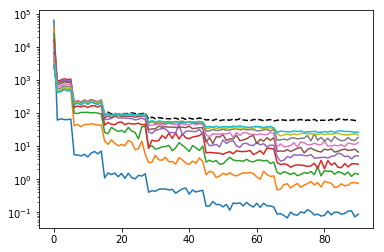

In [33]:
power = norm(sh, axis=0)
semilogy(power, 'k--');

power = norm(S/scale, axis=0).T
semilogy(power[:,1:]);


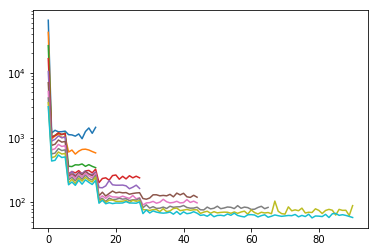

In [76]:
Scomp = msmt.calcsig(data[mask], grad, lmax) * scale

powercomp = norm(Scomp/scale, axis=0).T
semilogy(powercomp[:,1:]);


Residuals per shell:

In [34]:
from dwichd.sh import modshbasiscart
shb = modshbasiscart(lmax, grad[:,0], grad[:,1], grad[:,2])

res = zeros(mask.shape+(M,))
for k, b in enumerate(bvals):
    ii = grad[:,3]==b
    pred = einsum('gc,vc->vg', shb[ii,:], S[:,k,:] / scale[k])
    res[mask,k] = norm(data[mask][:,ii] - pred, axis=1)

r_sh = sqrt(mean(sum(res[mask]**2, axis=1)))
#f = np.sum(res[mask]**2)
print(r_sh)

26.591113181770723


With rescaling:

## SH-SVD basis

In [35]:
idx = zeros((lmax//2+1,S.shape[-1]), dtype=bool)
n2 = 0
for l in range(0,lmax+1,2):
    n1, n2 = n2, (l+1)*(l+2)//2
    idx[l//2,n1:n2] = True


In [36]:
s = zeros((lmax//2+1, M))
e = zeros(s.shape)
U = zeros((lmax//2+1, M, M))
V = zeros((lmax//2+1, M, S.shape[0]*(2*lmax+1)))
for l in range(0,lmax+1,2):
    T = np.rollaxis(S[:,:,idx[l//2]], 1).reshape((M,-1))
    U[l//2], s[l//2], V[l//2,:,:T.shape[1]] = svd(T, False)
    U[l//2] /= scale
    e[l//2] = s[l//2]**2 / (2*l+1)


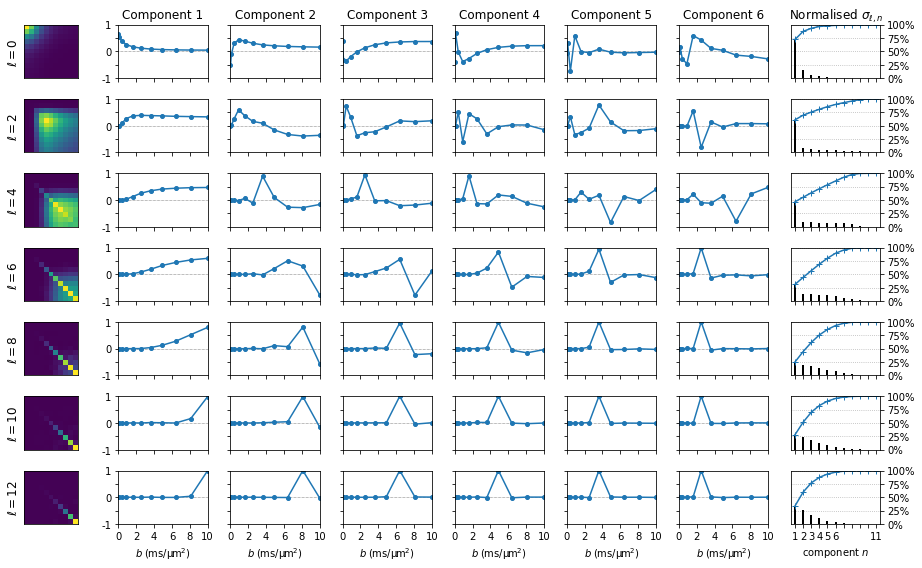

In [37]:
N = 6
bx = linspace(0, max(bvals),6)
blabels = [str(int(b/1000)) for b in bx]
clabels = [str(m+1) if m<N or m==M-1 else '' for m in range(M)]

figure(figsize=(13,8))
for l in range(0,lmax+1,2):
    # show S.S^T
    subplot(lmax//2+1, N+2, (N+2)*(l//2)+1)
    #imshow(dot(U[l//2] * scale, dot(diag(e[l//2]), scale.T * U[l//2].T)), aspect='equal', interpolation='nearest')
    imshow(dot(U[l//2], dot(diag(e[l//2]), U[l//2].T)), aspect='equal', interpolation='nearest')
    #xticks(range(M)[::2], ['',]*len(blabels) if l<lmax else blabels)
    #yticks(range(M)[::2], blabels)
    ylabel(r'$\ell = '+str(l)+'$', fontsize=12)
    #if l==lmax:
    #    xlabel(r'$b\;(\mathrm{ms}/\mathrm{\mu\!m}^2)$')
    xticks([], []), yticks([], [])
    # plot basis functions
    for k in range(N):
        subplot(lmax//2+1, N+2, (N+2)*(l//2)+k+2)
        plot(bvals, zeros(bvals.shape), 'k:', lw=0.5)
        plot(bvals, sign(mean(U[l//2,:,k])) * U[l//2,:,k] * squeeze(scale), 'o-', ms=4)
        xlim(0,bx[-1])
        xticks(bx, ['',]*len(blabels) if l<lmax else blabels)
        ylim(-1,1)
        yticks(linspace(-1,1,5), ['-1', '', '0', '', '1'] if k==0 else ['',]*5)
        if l==lmax:
            xlabel(r'$b\;(\mathrm{ms}/\mathrm{\mu\!m}^2)$')
        if l==0:
            title('Component '+str(k+1))
        if s[l//2,k] < 1e-6:
            gca().patch.set_facecolor('whitesmoke')
            gca().lines.pop()
    # plot variance plot
    subplot(lmax//2+1, N+2, (N+2)*(l//2)+N+2)
    vlines(range(1,M+1), 0.0, 100*s[l//2]/sum(s[l//2]), lw=2)
    plot(range(1,M+1), 100*cumsum(s[l//2])/sum(s[l//2]), '+-')
    ylim(0,100)
    yticks(linspace(0,100,5), [str(25*k)+'%' for k in range(5)])
    gca().yaxis.tick_right()
    gca().yaxis.grid(ls=':')
    xticks(range(1,M+1), ['',]*M if l<lmax else clabels)
    if l==lmax:
        xlabel(r'component $n$')
    if l==0:
        title(r'Normalised $\sigma_{\ell,n}$')
tight_layout()

savefig('shard-basis-s1.pdf')

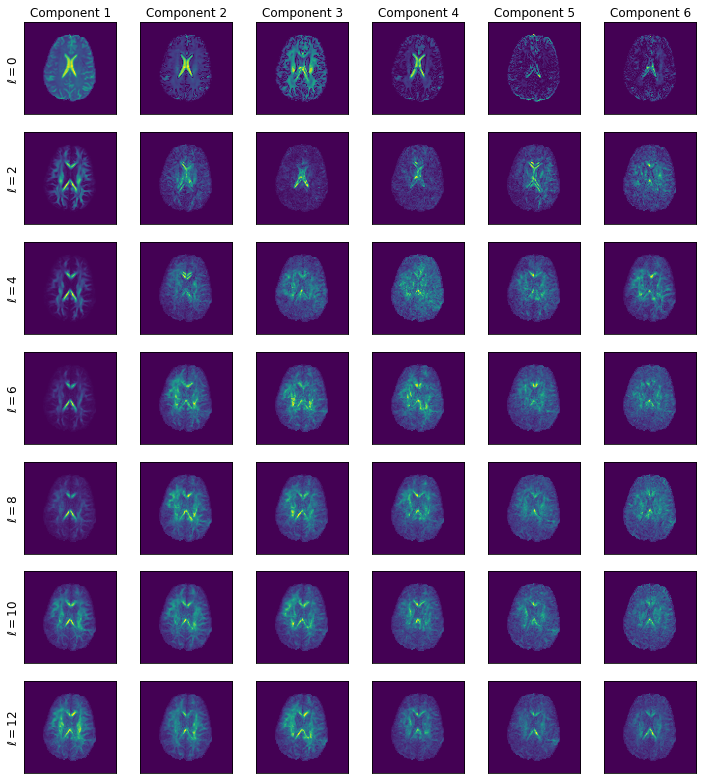

In [38]:
im = zeros(mask.shape)
figure(figsize=(10,11))
for l in range(0,lmax+1,2):
    n = 2*l+1
    w = norm([V[l//2,:,j:S.shape[0]*n:n] for j in range(n)], axis=0)
    # plot weights
    for k in range(N):
        if s[l//2,k] < 1e-6:
            break
        im[mask] = w[k]
        subplot(lmax//2+1, N, N*(l//2)+k+1)
        imshow(im[:,:,sliceidx].T, origin='lower')
        xticks([], []), yticks([], [])
        if l==0:
            title('Component '+str(k+1))
        if k==0:
            ylabel(r'$\ell = '+str(l)+'$', fontsize=12)
tight_layout()

savefig('shard-components-s1.pdf')

### Naive low-rank basis

In [39]:
from dwichd.sh import modshbasiscart

def shsvd0_matrix(lmax, grad):
    ''' Expects U to be globally defined. '''
    B = modshbasiscart(lmax, grad[:,0], grad[:,1], grad[:,2])
    bidx = array([grad[:,3]==b for b in bvals]).T
    Bfull = []
    for l in range(0, lmax+1, 2):
        n1, n2 = (l-1)*l//2, (l+1)*(l+2)//2
        for n in range(0, min((lmax-l)//2+1, U.shape[2])):
            Bfull += [ dot(bidx, U[l//2,:,n])[:,newaxis] * B[:,n1:n2] ]
    return np.hstack(Bfull)


In [40]:
x = arange(0,lmax+1,2)
r_shsvd0 = zeros(x.shape + (np.sum(mask),))
p_shsvd0 = zeros(x.shape)
for i, n in enumerate(x):
    Mshsvd0 = shsvd0_matrix(n, grad)
    coefs = dot(data[mask], pinv(Mshsvd0).T)
    pred  = dot(coefs, Mshsvd0.T)
    r_shsvd0[i] = norm( data[mask] - pred , axis=-1)
    p_shsvd0[i] = Mshsvd0.shape[1]


### Optimal low-rank basis

In [41]:
from dwichd.sh import modshbasiscart

B = modshbasiscart(lmax, grad[:,0], grad[:,1], grad[:,2])
bidx = array([grad[:,3]==b for b in bvals]).T

Bfull = []
p = 0
pp = []
ss = []
for i, j in zip(*np.unravel_index(np.argsort(e.ravel())[::-1], s.shape)):
    if s[i,j] < 1e-6 or p > len(grad) or p >= max(p_shsvd0):
        break
    l = 2*i
    n1, n2 = (l-1)*l//2, (l+1)*(l+2)//2
    p += n2-n1
    pp += [p,]
    ss += [s[i,j],]
    print( l, j, sqrt(e[i,j]/S.shape[0]), p )
    Bfull += [dot(bidx, U[i,:,j])[:,newaxis] * B[:,n1:n2]]
Bfull = np.hstack(Bfull)
pp = array(pp)

0 0 229.30790407766835 1
0 1 48.07534872967007 2
0 2 17.84586715998504 3
0 3 11.08062443328946 4
2 0 7.335925188199025 9
0 4 4.30312450615967 10
0 5 2.211754089597128 11
4 0 2.088665395847058 20
0 6 1.5967003942428115 21
2 1 1.0418538891845626 26
0 7 0.7723222869854094 27
0 8 0.7111778993862385 28
2 2 0.6951060815517843 33
6 0 0.6802316320109504 46
2 3 0.6293793630587254 51
2 4 0.5933146044196884 56
0 9 0.5015391774130205 57
2 5 0.49600623533710453 62
0 10 0.4393853728500754 63
2 6 0.4033576665907212 68
4 1 0.381873506692968 77
4 2 0.37050462816038865 86
2 7 0.35443344468030036 91
2 8 0.34428206658150595 96
4 3 0.3422396746704708 105
4 4 0.3328773519429335 114
4 5 0.3170538240569435 123
8 0 0.30780142154246165 140
4 6 0.30569179239089217 149
6 1 0.28334283384774483 162
6 2 0.2727369962326708 175
6 3 0.26429180019009363 188
6 4 0.24302338971595 201
8 1 0.23673350229741727 218
4 7 0.228757804699141 227
8 2 0.20868489369152432 244
6 5 0.20294408033518493 257


In [42]:
r_shsvd = np.zeros(shape(pp) + (np.sum(mask),))
for i, n in enumerate(pp):
    coef = dot(data[mask], pinv(Bfull[:,:n]).T)
    pred = dot(coef, Bfull[:,:n].T)
    r_shsvd[i] = norm(data[mask] - pred, axis=-1)

In [43]:
norm(pinv(Bfull) - Bfull.T)

21.753440393715543

## Spherical bessel function basis

In [23]:
from scipy.optimize import brentq

def findnroots(f, n, start=0.0, step=0.01):
    ''' Find the first n roots of function f(x).
    '''
    a, b = start, start+step
    for k in range(n):
        while np.sign(f(a)) == np.sign(f(b)):
            a, b = b, b+step
        yield brentq(f, a, b)
        a, b = b, b+step

In [24]:
from scipy.special import spherical_jn

Z1 = array([[x for x in findnroots(lambda r: spherical_jn(l, r, True), 10, start=l)] for l in range(0,lmax+1, 2)])

def normfactor1(l, n, a=1.0):
    return a**3 / 2 * (1 - l*(l+1) / Z1[l//2,n]**2) * spherical_jn(l, Z1[l//2,n])**2 if not (l+n)==0 else a**3 / 3

def radfun1(l, n, r, a=1.0):
    return spherical_jn(l, Z1[l//2,n]/a * r) / np.sqrt(normfactor1(l, n, a))

In [25]:
from dwichd.sh import modshbasiscart

def bessel_matrix(lmax, grad):
    q = np.sqrt(grad[:,3])
    qmax = np.max(q)
    B = modshbasiscart(lmax, grad[:,0], grad[:,1], grad[:,2])
    Bfull = []
    for l in range(0, lmax+1, 2):
        n1, n2 = (l-1)*l//2, (l+1)*(l+2)//2
        for n in range(0, (lmax-l)//2+1):
            Bfull += [ radfun1(l, n, q, qmax)[:,np.newaxis] * B[:,n1:n2] ]
    return np.hstack(Bfull)


In [26]:
x = arange(0,lmax+1,2)
r_bessel = zeros(x.shape + (np.sum(mask),))
p_bessel = zeros(x.shape)
for i, n in enumerate(x):
    Mbessel = bessel_matrix(n, grad)
    besselcoefs = dot(data[mask], pinv(Mbessel).T)
    besselpred  = dot(besselcoefs, Mbessel.T)
    r_bessel[i] = norm( data[mask] - besselpred , axis=-1)
    p_bessel[i] = Mbessel.shape[1]


## SHORE basis

In [27]:
def shore_ncoefs(lmax):
    return sum([(lmax//2+1-l//2)*(2*l+1) for l in range(0,lmax+1,2)])

print(list(map(shore_ncoefs, range(0,lmax+1,2))))

[1, 7, 22, 50, 95, 161, 252]


In [28]:
from dipy.reconst.shore import shore_matrix
from dipy.core.gradients import gradient_table

gtab = gradient_table(grad[:,3], grad[:,:3])
datasub = data[mask][::100,:]

def eval_shore(D, n, scale):
    Mshore = shore_matrix(n, scale, gtab, 1./(4*pi**2))
    shorecoefs = dot(D, pinv(Mshore).T)
    shorepred  = dot(shorecoefs, Mshore.T)
    return norm( D - shorepred )**2

from scipy.optimize import minimize

zeta = minimize(lambda x: eval_shore(datasub, 0, x), 700.0)['x']
print(zeta)

[471.84139449]


/home/dc16/dev/anaconda3/lib/python3.5/site-packages/dipy/core/geometry.py:128: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(z / r)


In [29]:
from dipy.reconst.shore import shore_matrix
from dipy.core.gradients import gradient_table

gtab = gradient_table(grad[:,3], grad[:,:3])

x = arange(0,lmax+1,2)
r_shore = zeros(x.shape + (np.sum(mask),))
p_shore = zeros(x.shape)
for i, n in enumerate(x):
    Mshore = shore_matrix(n, zeta, gtab, 1./(4*pi**2))
    shorecoefs = dot(data[mask], pinv(Mshore).T)
    shorepred  = dot(shorecoefs, Mshore.T)
    r_shore[i] = norm( data[mask] - shorepred , axis=-1)
    p_shore[i] = Mshore.shape[1]


/home/dc16/dev/anaconda3/lib/python3.5/site-packages/dipy/core/geometry.py:128: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(z / r)


## Plotting

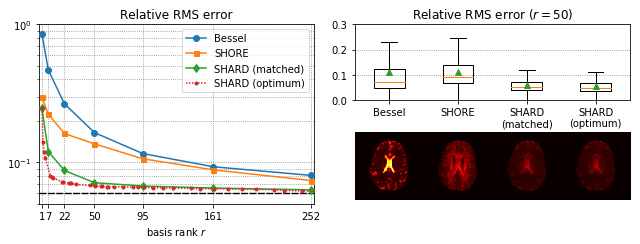

In [45]:
SE = sqrt(mean(norm(data[mask], axis=1)**2))
figure(figsize=(9,3.5))

# 1) Plot RMSE for basis rank
subplot2grid((2,2), (0,0), rowspan=2)

semilogy(p_bessel, sqrt(mean(r_bessel**2, axis=1))/SE, 'o-', label='Bessel', zorder=3)
semilogy(p_shore, sqrt(mean(r_shore**2, axis=1))/SE, 's-', label='SHORE', zorder=4, ms=5)
semilogy(p_shsvd0, sqrt(mean(r_shsvd0**2, axis=1))/SE, 'd-', label='SHARD (matched)', zorder=5)
semilogy(pp, sqrt(mean(r_shsvd**2, axis=1))/SE, '.', label='SHARD (optimum)', linestyle=(0, (1,1)), zorder=6)

xticks(p_shore)
xlim(min(p_shore)-3,max(p_shore)+3)
ylim(0.05, 1.0)
semilogy(xlim(), [r_sh/SE, r_sh/SE], 'k', linestyle=(0, (5,1)), zorder=1, lw=1.4)
grid('on', which='both', color='gray', ls=':')
gca().set_axisbelow(True)

xlabel(r'basis rank $r$')
#ylabel('RMSE / data power')
title('Relative RMS error')
legend()

# 2) Plot RMSE images and boxplots
#SE = norm(data[mask], axis=1)
i = 3; rr = sum([pp<p_shore[i]]);
res0 = zeros(mask.shape); res0[mask] = nan_to_num(r_bessel[i]/SE)
res1 = zeros(mask.shape); res1[mask] = nan_to_num(r_shore[i]/SE)
res2 = zeros(mask.shape); res2[mask] = nan_to_num(r_shsvd0[i]/SE)
res3 = zeros(mask.shape); res3[mask] = nan_to_num(r_shsvd[rr]/SE)

# 2.a) boxplots
subplot2grid((2,2), (0,1))
boxplot([res0[mask], res1[mask], res2[mask], res3[mask]], showfliers=False, showmeans=True,
        labels=['Bessel', 'SHORE', 'SHARD\n(matched)', 'SHARD\n(optimum)'])
title(r'Relative RMS error ($r = ' + str(int(p_shore[i])) + '$)')
ylim(0, .3)
yticks(linspace(0,.3,4))
gca().yaxis.grid(color='gray', ls=':')
gca().set_axisbelow(True)

# 2.b) images
subplot2grid((2,2), (1,1))
imshow(hstack((res0[:,:,sliceidx].T, res1[:,:,sliceidx].T, res2[:,:,sliceidx].T, res3[:,:,sliceidx].T)), origin='lower', cmap='hot')
axis('off')

# Layout and save
tight_layout()
savefig('shard-rmse-s1.pdf')

## Prediction error

Generate prediction for volume from other volumes in b=2500 shell, vs from all other volumes in basis of matched rank:

In [ ]:
b = 2500.
bidx = grad[:,3]==b

D = data[mask][:,bidx]
ll = max([l for l in range(0,lmax+1,2) if msmt._l2n(l) <= D.shape[1]-1])
B1 = modshbasiscart(ll, grad[bidx,0], grad[bidx,1], grad[bidx,2])
nn = pp[sum([pp<=msmt._l2n(ll)])-1]
B2 = Bfull[:,:nn]
Dp1 = zeros(D.shape)
Dp2 = zeros(D.shape)
for i in range(D.shape[1]):
    ii = ones(D.shape[1], dtype=bool); ii[i] = False;
    Dp1[:,i] = dot( dot(B1[i,:], pinv(B1[ii,:])) , D[:,ii].T ).T
    ii = ones(grad.shape[0], dtype=bool); j = find(bidx)[i]; ii[j] = False;
    Dp2[:,i] = dot( dot(B2[j,:], pinv(B2[ii,:])) , data[mask][:,ii].T ).T

In [ ]:
norm(Dp1-D)

In [ ]:
norm(Dp2-D)

In [ ]:
boxplot([np.abs(Dp1-D), np.abs(Dp2-D)], showfliers=False, labels=['SH', 'SH-SVD'], showmeans=True)
title('Abs. prediction error')
ylim(0, 4)

Now across all shells:

In [ ]:
En1 = zeros((len(bvals), 3))
En2 = zeros((len(bvals), 3))
for k, b in enumerate(bvals):
    bidx = grad[:,3]==b
    D = data[mask][:,bidx]
    ll = max([l for l in range(0,lmax+1,2) if msmt._l2n(l) <= D.shape[1]-10])
    B1 = modshbasiscart(ll, grad[bidx,0], grad[bidx,1], grad[bidx,2])
    nn = pp[sum([pp<=msmt._l2n(ll)])-1]
    B2 = Bfull[:,:nn]
    Dp1 = zeros(D.shape)
    Dp2 = zeros(D.shape)
    for i in range(D.shape[1]):
        ii = ones(D.shape[1], dtype=bool); ii[i] = False;
        Dp1[:,i] = dot( dot(B1[i,:], pinv(B1[ii,:])) , D[:,ii].T ).T
        ii = ones(grad.shape[0], dtype=bool); j = find(bidx)[i]; ii[j] = False;
        Dp2[:,i] = dot( dot(B2[j,:], pinv(B2[ii,:])) , data[mask][:,ii].T ).T
    En1[k] = np.percentile(np.abs(Dp1-D), [25., 50., 75.])
    En2[k] = np.percentile(np.abs(Dp2-D), [25., 50., 75.])

In [ ]:
figure(figsize=(3.8,3))

plot(qvals, En1[:,1], 'o-', lw=2, ms=4)
fill_between(qvals, En1[:,0], En1[:,2], alpha=0.25)

plot(qvals, En2[:,1], 's-', lw=2, ms=4)
fill_between(qvals, En2[:,0], En2[:,2], alpha=0.25)

ylim(0, 10)
xticks(arange(0,101,20), bvals[::2].astype(int))

title('Median absolute prediction error')
xlabel(r'$b$-value')
legend(['single-shell', 'multi-shell'])

grid('on', which='both', color='gray', ls=':')
gca().set_axisbelow(True)
tight_layout()

Prediction error markedly lower for SH-SVD multi-shell basis, compared to single-shell prediction, even though basis rank is matched in the comparison. Jumps in single-shell curve due to SH rank vs. no. sampled: every _step_ of $\ell_\text{max}$ makes prediction error spike.

In [64]:
from dwichd import msmt

def sh_crossval(data, grad):
    ll = [l for l in range(0,lmax+1,2) if msmt._l2n(l) <= data.shape[1]-1]
    e = [norm(data - sh_pred(data, grad, l)) for l in ll]
    return ll[argmin(e)]
        
def sh_pred(data, grad, l):
    B = modshbasiscart(l, grad[:,0], grad[:,1], grad[:,2])
    P = zeros(data.shape)
    for i in range(data.shape[1]):
        ii = ones(data.shape[1], dtype=bool); ii[i] = False;
        P[:,i] = dot(data[:,ii], dot(B[i,:], pinv(B[ii,:])))
    return P


In [65]:
#tmp = np.load('s02_pred_errors-new.npz')
#E1 = tmp['arr_0']
#E2 = tmp['arr_1']
#E3 = tmp['arr_2']

In [66]:
E1 = zeros((len(bvals), 3))
for k, b in enumerate(bvals):
    bidx = grad[:,3]==b
    D = data[mask][:,bidx]
    ll = sh_crossval(D, grad[bidx])
    print(ll)
    Dp1 = sh_pred(D, grad[bidx], ll)
    E1[k] = np.percentile(np.abs(Dp1-D), [25., 50., 75.])

0
0
2
2
2
4
4
4
4
6
6


In [67]:
def shsvd_crossval(data, bidx=None):
    if bidx is None:
        bidx = np.ones((data.shape[1],), dtype=np.bool)
    e = [norm(data[:,bidx] - shsvd_pred(data, p, bidx)) for p in pp]
    return pp[argmin(e)]

def shsvd_pred(data, p, bidx=None):
    if bidx is None:
        bidx = np.ones((data.shape[1],), dtype=np.bool)
    P = zeros(data[:,bidx].shape)
    for i in range(P.shape[1]):
        ii = ones(data.shape[1], dtype=bool); j = find(bidx)[i]; ii[j] = False;
        P[:,i] = dot(data[:,ii], dot(Bfull[j,:p], pinv(Bfull[ii,:p])))
    return P


In [68]:
nn = shsvd_crossval(data[mask])
print(nn)

E2 = zeros((len(bvals), 3))
for k, b in enumerate(bvals):
    bidx = grad[:,3]==b
    D = data[mask][:,bidx]
    Dp2 = shsvd_pred(data[mask], nn, bidx)
    E2[k] = np.percentile(np.abs(Dp2-D), [25., 50., 75.])

46


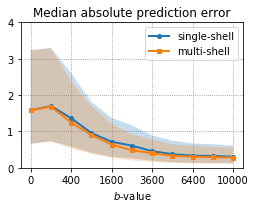

In [69]:
figure(figsize=(3.8,3))

plot(qvals, E1[:,1], 'o-', lw=2, ms=4)
fill_between(qvals, E1[:,0], E1[:,2], alpha=0.25)

plot(qvals, E2[:,1], 's-', lw=2, ms=4)
fill_between(qvals, E2[:,0], E2[:,2], alpha=0.25)

ylim(0, 4)
xticks(arange(0,101,20), bvals[::2].astype(int))

title('Median absolute prediction error')
xlabel(r'$b$-value')
legend(['single-shell', 'multi-shell'])

grid('on', which='both', color='gray', ls=':')
gca().set_axisbelow(True)
tight_layout()

In [70]:
E3 = zeros((len(bvals), 3))
for k, b in enumerate(bvals):
    bidx = grad[:,3]==b
    D = data[mask][:,bidx]
    nn = shsvd_crossval(data[mask], bidx)
    print(nn)
    Dp3 = shsvd_pred(data[mask], nn, bidx)
    E3[k] = np.percentile(np.abs(Dp3-D), [25., 50., 75.])

10
218
26
26
21
51
56
56
57
62
62


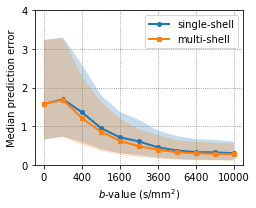

In [71]:
figure(figsize=(3.8,3))

plot(qvals, E1[:,1], 'o-', lw=2, ms=4)
fill_between(qvals, E1[:,0], E1[:,2], alpha=0.25)

plot(qvals, E3[:,1], 's-', lw=2, ms=4)
fill_between(qvals, E3[:,0], E3[:,2], alpha=0.25)

ylim(0, 4)
xticks(arange(0,101,20), bvals[::2].astype(int))

ylabel('Median prediction error')
xlabel(r'$b$-value (s/mm$^2$)')
legend(['single-shell', 'multi-shell'])

grid('on', which='both', color='gray', ls=':')
gca().set_axisbelow(True)
tight_layout()
#savefig('prederr_s02.pdf')

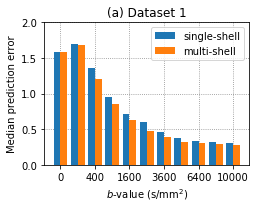

In [75]:
figure(figsize=(3.8,3))

barwidth = 4.
bar(qvals-barwidth/2, E1[:,1], barwidth)
bar(qvals+barwidth/2, E3[:,1], barwidth)

ylim(0, 2)
xticks(arange(0,101,20), bvals[::2].astype(int))

ylabel('Median prediction error')
xlabel(r'$b$-value (s/mm$^2$)')
legend(['single-shell', 'multi-shell'])
title('(a) Dataset 1')

grid('on', which='both', color='gray', ls=':')
gca().set_axisbelow(True)

tight_layout()
savefig('shard-prederr-s1-new.pdf')

In [73]:
print(np.round( (E1[:,1]-E3[:,1]) / E1[:,1] * 100, 2))

[-0.    0.93 11.27  9.75 11.88 21.24 12.74 12.25  8.78 11.72  7.81]


In [74]:
np.savez('s02_pred_errors-new.npz', E1, E2, E3)

## Save projected data for CNSF

In [ ]:
out = I.empty_as(I)
for l in range(0, lmax+1, 2):
    Bl = shsvd0_matrix(l, grad)
    proj = dot(Bl, pinv(Bl))
    out.data = dot(data, proj.T)
    out.save('/data/SH-SVD/workup/s02/shsvd/pred-'+str(l)+'.mif')

## Outlier rejection

In [46]:
def irls2(A, y, loss='linear', C=1.0, kmax=5):
    x = lstsq(A, y, rcond=None)[0]
    if loss is 'linear':
        return x
    m, n = A.shape
    w0 = ones((m,))
    r = y - dot(A, x)
    s_mad = 1.48 * median(np.abs(r - median(r)))   # * sqrt(1-diag(dot(A, pinv(A))))
    for k in range(kmax):
        r /= C*s_mad
        if loss is 'soft_l1':
            w = 1. / sqrt(1+r*r)
        elif loss is 'huber':
            w = 1. / where(np.abs(r)>1, np.abs(r), 1.)
        elif loss is 'cauchy':
            w = 1. / (1+r*r)
        elif loss is 'bisquare':
            w = np.where(np.abs(r) < 1, (1-r*r)**2, 0)
        elif loss is 'atan':
            w = 1. / (1+r**4)
        else:
            w = ones((m,))
        w[~isfinite(w)] = 1.
        x = lstsq(sqrt(w)[:,newaxis]*A, sqrt(w)*y, rcond=None)[0]
        r = y - dot(A, x)
        if np.max(np.abs(w-w0)) < 1e-3:
            break
        else:
            w0[:] = w
    return x, w

Evaluate difference from reference in random subsample

In [47]:
from scipy.ndimage.morphology import binary_erosion
idx = np.where(binary_erosion(mask, iterations=2).ravel())[0]
np.random.shuffle(idx)
idx = idx[:1000]

sample = data.reshape((-1,data.shape[3]))[idx,:]

In [48]:
orp = linspace(0,0.3,7)
ori = rand(*sample.shape)[newaxis,:,:] > orp[:,newaxis,newaxis]
ori.shape

(7, 1000, 550)

In [49]:
orsample = sample * ori
orsample.shape

(7, 1000, 550)

Matched SHARD basis

In [50]:
Lor = 6
Bor = shsvd0_matrix(Lor, grad)
m, n = Bor.shape

samplecoefs0 = lstsq(Bor, sample.T, rcond=None)[0].T

In [51]:
csample = zeros((len(orp),3,)+samplecoefs0.shape)
wsample = ones((len(orp),3,)+sample.shape)
rmse = zeros((3,)+orp.shape)
for i, p in enumerate(orp):
    for v in range(1000):
        csample[i,0,v] = irls2(Bor, orsample[i,v], loss='linear')
        csample[i,1,v], wsample[i,1,v] = irls2(Bor, orsample[i,v], loss='soft_l1', C=1.345)
        csample[i,2,v], wsample[i,2,v] = irls2(Bor, orsample[i,v], loss='cauchy', C=2.385)
    for j in range(3):
        rmse[j,i] = norm(csample[i,j] - samplecoefs0)

samplepred = dot(samplecoefs0, Bor.T)
rmse2 = norm( dot(csample, Bor.T) - sample , axis=(-2,-1))

SHORE basis:

In [52]:
zeta2 = minimize(lambda x: eval_shore(datasub, Lor, x), 700.0)['x'][0]
Bshoreor = shore_matrix(Lor, zeta2, gtab, 1./(4*pi**2))
samplecoefs0_shore = lstsq(Bshoreor, sample.T, rcond=None)[0].T

csample_shore = zeros((len(orp),3,)+samplecoefs0.shape)
wsample_shore = ones((len(orp),3,)+sample.shape)
rmse_shore = zeros((3,)+orp.shape)
for i, p in enumerate(orp):
    for v in range(1000):
        csample_shore[i,0,v] = irls2(Bshoreor, orsample[i,v], loss='linear')
        csample_shore[i,1,v], wsample_shore[i,1,v] = irls2(Bshoreor, orsample[i,v], loss='soft_l1', C=1.345)
        csample_shore[i,2,v], wsample_shore[i,2,v] = irls2(Bshoreor, orsample[i,v], loss='cauchy', C=2.385)
    for j in range(3):
        rmse_shore[j,i] = norm(csample_shore[i,j] - samplecoefs0_shore)

samplepred_shore = dot(samplecoefs0_shore, Bshoreor.T)
rmse2_shore = norm( dot(csample_shore, Bshoreor.T) - sample , axis=(-2,-1))

/home/dc16/dev/anaconda3/lib/python3.5/site-packages/dipy/core/geometry.py:128: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(z / r)


Bessel basis:

In [53]:
Bbesselor = bessel_matrix(Lor, grad)
samplecoefs0_bessel = lstsq(Bbesselor, sample.T, rcond=None)[0].T

csample_bessel = zeros((len(orp),3,)+samplecoefs0.shape)
wsample_bessel = ones((len(orp),3,)+sample.shape)
rmse_bessel = zeros((3,)+orp.shape)
for i, p in enumerate(orp):
    for v in range(1000):
        csample_bessel[i,0,v] = irls2(Bbesselor, orsample[i,v], loss='linear')
        csample_bessel[i,1,v], wsample_bessel[i,1,v] = irls2(Bbesselor, orsample[i,v], loss='soft_l1', C=1.345)
        csample_bessel[i,2,v], wsample_bessel[i,2,v] = irls2(Bbesselor, orsample[i,v], loss='cauchy', C=2.385)
    for j in range(3):
        rmse_bessel[j,i] = norm(csample_bessel[i,j] - samplecoefs0_bessel)

samplepred_bessel = dot(samplecoefs0_bessel, Bbesselor.T)
rmse2_bessel = norm( dot(csample_bessel, Bbesselor.T) - sample , axis=(-2,-1))

Plots:

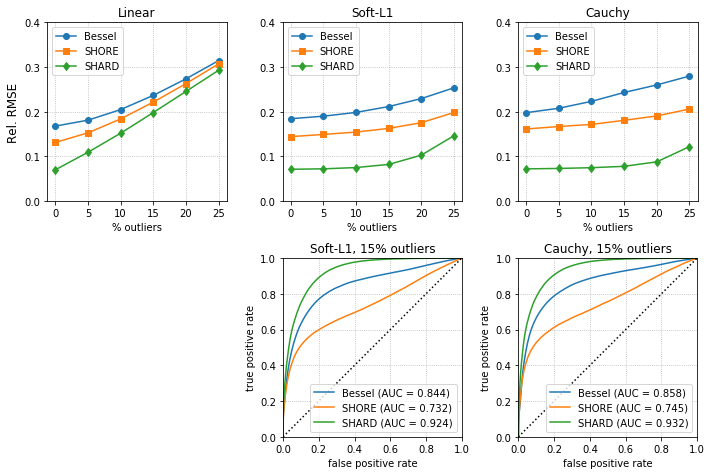

In [60]:
Z = norm(sample)

figure(figsize=(10,6.7))
yt=linspace(0,0.4,5)

subplot(2,3,1)
plot(orp[:-1]*100, rmse2_bessel[:-1,0]/Z, 'o-')
plot(orp[:-1]*100, rmse2_shore[:-1,0]/Z, 's-')
plot(orp[:-1]*100, rmse2[:-1,0]/Z, 'd-')
yticks(yt)
grid(ls=':')
xticks(orp[:-1]*100)
xlabel('% outliers')
ylabel('Rel. RMSE', fontsize=12)
title('Linear')
legend(['Bessel', 'SHORE', 'SHARD'], loc=2)
#legend(['Bessel', 'SHORE', 'SHARD'], loc=8, ncol=3, bbox_to_anchor=(0.5, -1.25), borderaxespad=0.)

subplot(2,3,2)
plot(orp[:-1]*100, rmse2_bessel[:-1,1]/Z, 'o-')
plot(orp[:-1]*100, rmse2_shore[:-1,1]/Z, 's-')
plot(orp[:-1]*100, rmse2[:-1,1]/Z, 'd-')
yticks(yt)
grid(ls=':')
xticks(orp[:-1]*100)
xlabel('% outliers')
title('Soft-L1')
legend(['Bessel', 'SHORE', 'SHARD'], loc=2)

subplot(2,3,3)
plot(orp[:-1]*100, rmse2_bessel[:-1,2]/Z, 'o-')
plot(orp[:-1]*100, rmse2_shore[:-1,2]/Z, 's-')
plot(orp[:-1]*100, rmse2[:-1,2]/Z, 'd-')
yticks(yt)
grid(ls=':')
xticks(orp[:-1]*100)
xlabel('% outliers')
title('Cauchy')
#legend(['Bessel', 'SHORE', 'SHARD'], loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
legend(['Bessel', 'SHORE', 'SHARD'], loc=2)


## ----------------------

from sklearn.metrics import roc_curve, auc
i = 3
yori = 1-ori[i,:,:].flatten()
AUC = [['', ''], ['', ''], ['', '']]

subplot(2,3,5)
fpr, tpr, _ = roc_curve(yori, 1-wsample_bessel[i,1,:,:].flatten())
AUC[0][0] = '%0.3f' % auc(fpr, tpr)
plot(fpr, tpr, label='Bessel (AUC = %0.3f)' % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(yori, 1-wsample_shore[i,1,:,:].flatten())
AUC[1][0] = '%0.3f' % auc(fpr, tpr)
plot(fpr, tpr, label='SHORE (AUC = %0.3f)' % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(yori, 1-wsample[i,1,:,:].flatten())
AUC[2][0] = '%0.3f' % auc(fpr, tpr)
plot(fpr, tpr, label='SHARD (AUC = %0.3f)' % auc(fpr, tpr))

plot([0,1],[0,1],'k:')
axis('scaled')
xlim(0,1)
ylim(0,1)
grid(ls=':')

title('Soft-L1, ' + str(int(orp[i]*100)) + '% outliers')
xlabel('false positive rate')
ylabel('true positive rate')
legend(loc=4)

subplot(2,3,6)
fpr, tpr, _ = roc_curve(yori, 1-wsample_bessel[i,2,:,:].flatten())
AUC[0][1] = '%0.3f' % auc(fpr, tpr)
plot(fpr, tpr, label='Bessel (AUC = %0.3f)' % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(yori, 1-wsample_shore[i,2,:,:].flatten())
AUC[1][1] = '%0.3f' % auc(fpr, tpr)
plot(fpr, tpr, label='SHORE (AUC = %0.3f)' % auc(fpr, tpr))
fpr, tpr, _ = roc_curve(yori, 1-wsample[i,2,:,:].flatten())
AUC[2][1] = '%0.3f' % auc(fpr, tpr)
plot(fpr, tpr, label='SHARD (AUC = %0.3f)' % auc(fpr, tpr))

plot([0,1],[0,1],'k:')
axis('scaled')
xlim(0,1)
ylim(0,1)
grid(ls=':')

title('Cauchy, ' + str(int(orp[i]*100)) + '% outliers')
xlabel('false positive rate')
ylabel('true positive rate')
legend(loc=4)

#subplot(2,3,4)
#table(cellText=AUC, rowLabels=['Bessel', 'SHORE', 'SHARD'], colLabels=['Soft-L1', 'Cauchy'],loc='upper center')
#axis('scaled')
#axis('off')
#title('Area under ROC curve')

tight_layout()
savefig('shard-or2-s1.pdf')

Sanity check:

In [55]:
shard_gt = zeros((len(orp),)+samplecoefs0.shape)
shore_gt = zeros((len(orp),)+samplecoefs0.shape)
bessel_gt = zeros((len(orp),)+samplecoefs0.shape)
for i in range(len(orp)):
    wsample_gt = np.array(ori[i], dtype=np.float)
    for v in range(1000):
        ww = wsample_gt[v,:]
        shard_gt[i,v,:] = lstsq(ww[:,newaxis] * Bor, ww * orsample[i,v], rcond=None)[0]
        shore_gt[i,v,:] = lstsq(ww[:,newaxis] * Bshoreor, ww * orsample[i,v], rcond=None)[0]
        bessel_gt[i,v,:] = lstsq(ww[:,newaxis] * Bbesselor, ww * orsample[i,v], rcond=None)[0]

In [56]:
shard_gt_rmse = norm( dot(shard_gt, Bor.T) - sample , axis=(-2,-1))
shore_gt_rmse = norm( dot(shore_gt, Bshoreor.T) - sample , axis=(-2,-1))
bessel_gt_rmse = norm( dot(bessel_gt, Bbesselor.T) - sample , axis=(-2,-1))

/home/dc16/dev/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


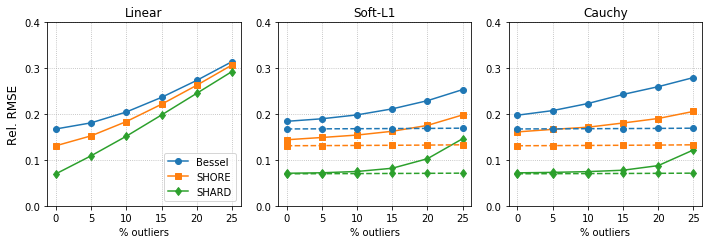

In [57]:
Z = norm(sample)

figure(figsize=(10,3.5))
yt=linspace(0,0.4,5)

subplot(1,3,1)
plot(orp[:-1]*100, rmse2_bessel[:-1,0]/Z, 'o-')
plot(orp[:-1]*100, rmse2_shore[:-1,0]/Z, 's-')
plot(orp[:-1]*100, rmse2[:-1,0]/Z, 'd-')
yticks(yt)
grid(ls=':')
xticks(orp[:-1]*100)
xlabel('% outliers')
ylabel('Rel. RMSE', fontsize=12)
title('Linear')
legend(['Bessel', 'SHORE', 'SHARD'], loc=4)

subplot(1,3,2)
plot(orp[:-1]*100, rmse2_bessel[:-1,1]/Z, 'o-')
plot(orp[:-1]*100, rmse2_shore[:-1,1]/Z, 's-')
plot(orp[:-1]*100, rmse2[:-1,1]/Z, 'd-')
gca().set_color_cycle(None)
plot(orp[:-1]*100, bessel_gt_rmse[:-1]/Z, 'o--')
plot(orp[:-1]*100, shore_gt_rmse[:-1]/Z, 's--')
plot(orp[:-1]*100, shard_gt_rmse[:-1]/Z, 'd--')
yticks(yt)
grid(ls=':')
xticks(orp[:-1]*100)
xlabel('% outliers')
title('Soft-L1')
#legend(['Bessel', 'SHORE', 'SHARD'], loc=4)

subplot(1,3,3)
plot(orp[:-1]*100, rmse2_bessel[:-1,2]/Z, 'o-')
plot(orp[:-1]*100, rmse2_shore[:-1,2]/Z, 's-')
plot(orp[:-1]*100, rmse2[:-1,2]/Z, 'd-')
gca().set_color_cycle(None)
plot(orp[:-1]*100, bessel_gt_rmse[:-1]/Z, 'o--')
plot(orp[:-1]*100, shore_gt_rmse[:-1]/Z, 's--')
plot(orp[:-1]*100, shard_gt_rmse[:-1]/Z, 'd--')
yticks(yt)
grid(ls=':')
xticks(orp[:-1]*100)
xlabel('% outliers')
title('Cauchy')
#legend(['Bessel', 'SHORE', 'SHARD'], loc=4)

tight_layout()

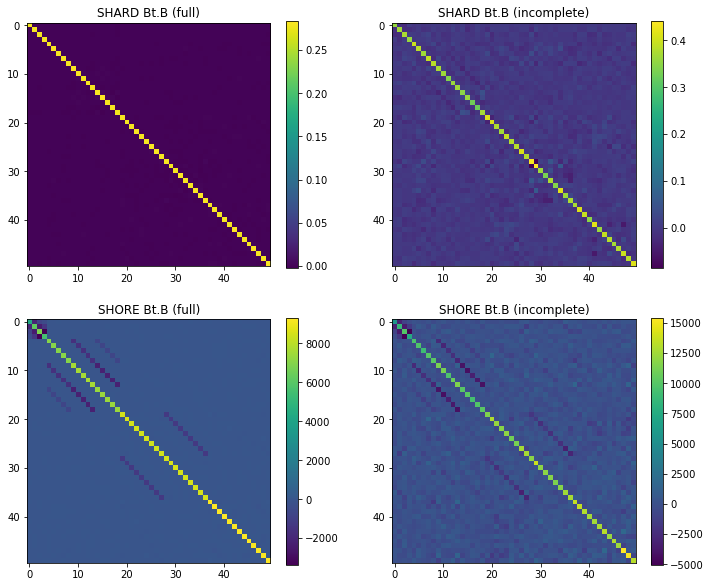

In [58]:
figure(figsize=(12,10))

subplot(2,2,1)
bb = Bor
imshow(dot(pinv(bb), pinv(bb).T)), colorbar()
title('SHARD Bt.B (full)')

subplot(2,2,2)
bb = Bor[ori[-2,0],:]
imshow(dot(pinv(bb), pinv(bb).T)), colorbar()
title('SHARD Bt.B (incomplete)')

subplot(2,2,3)
bb = Bshoreor
imshow(dot(pinv(bb), pinv(bb).T)), colorbar()
title('SHORE Bt.B (full)')

subplot(2,2,4)
bb = Bshoreor[ori[-2,0],:]
imshow(dot(pinv(bb), pinv(bb).T)), colorbar()
title('SHORE Bt.B (incomplete)')
